In [2]:
import polars as pl
import sys

from transformers.image_utils import valid_coco_detection_annotations

from models.PatchMixer import PatchMixerFeatureModel
import torch

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)
print(torch.__version__)
print(torch.cuda.get_device_name(0))
print(torch.__version__)
MAC_DIR = '/data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
else:
    DIR = MAC_DIR


tb_bas_oper_part_mst = (pl.read_parquet(DIR + 'tb_bas_oper_part_mst.parquet')
                        .select(['OPER_PART_NO', 'OPER_PART_NM'])
                        .rename({'OPER_PART_NO': 'oper_part_no', 'OPER_PART_NM': 'oper_part_nm'}))
tb_dyn_fcst_demand = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd.parquet')
                      .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                      .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                      .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))
tb_dyn_fcst_demand_sellout = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd_sellout.parquet')
                              .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                              .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                              .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


# Unique Value Check
Data를 확인해보니, TB_DYN_FCST_DEMAND_SELLOUT 과 TB_DYN_FCST_DEMAND는 동일한 테이블로 보임..


In [3]:
# oper_part_mst unique part
print(tb_bas_oper_part_mst.select(pl.col('oper_part_no')).n_unique())

# dyn_fcst_demand unique part/oper_part
print(tb_dyn_fcst_demand.select(pl.col('part_no')).n_unique())
print(tb_dyn_fcst_demand.select(pl.col('oper_part_no')).n_unique())

# dyn_fcst_demand_sellout unique part/oper_part
print(tb_dyn_fcst_demand_sellout.select(pl.col('part_no')).n_unique())
print(tb_dyn_fcst_demand_sellout.select(pl.col('oper_part_no')).n_unique())

97530
50233
43896
50233
43896


In [4]:
import datetime
from datetime import datetime
from date_util import DateUtil
date_util = DateUtil()

dyn_fcst_demand = tb_dyn_fcst_demand.with_columns([
    pl.col('demand_dt').cast(pl.Int64).map_elements(date_util.yyyymmdd_to_date, return_dtype = pl.Date)
])

dyn_demand_sellout = tb_dyn_fcst_demand_sellout.with_columns([
    pl.col('demand_dt').cast(pl.Int64).map_elements(date_util.yyyymmdd_to_date, return_dtype = pl.Date)
])

dyn_fcst_demand

part_no,oper_part_no,demand_dt,demand_qty
str,str,date,f64
"""T4240-71102BB""","""T4240-71102BB""",2018-01-01,3.0
"""T5210-34402""","""T5210-34402""",2018-01-01,1.0
"""T5210-30081""","""T5210-30081""",2018-01-01,1.0
"""T5210-65661""","""T5210-65661""",2018-01-01,1.0
"""T5210-66472""","""T5210-66472""",2018-01-01,1.0
…,…,…,…
"""U3215-52203""","""U3215-52203""",2024-02-05,30.0
"""T5710-69252""","""T5710-69252""",2024-02-05,2.0
"""DYD1-O07""","""DYD1-O07""",2024-02-05,4.0


In [5]:
dyn_fcst = (dyn_fcst_demand
                .join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
                .select(['oper_part_no', 'oper_part_nm', 'demand_dt','demand_qty'])
                .sort(['oper_part_no', 'demand_dt'])
                .with_columns([
                    pl.col('demand_qty').cum_sum().over('oper_part_no').alias('cumsum_qty')
                ])
              )
dyn_demand = (dyn_demand_sellout.join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
                    .select(['oper_part_no', 'oper_part_nm', 'demand_dt', 'demand_qty'])
                    .sort(['oper_part_no', 'demand_dt'])
                    .with_columns([
                        pl.col('demand_qty').cum_sum().over('oper_part_no').alias('cumsum_qty')
                 ])
               )

In [6]:
dyn_demand

oper_part_no,oper_part_nm,demand_dt,demand_qty,cumsum_qty
str,str,date,f64,f64
"""0001-1001""","""Quick Coupler""",2018-03-12,5.0,5.0
"""0001-1001""","""Quick Coupler""",2018-11-23,3.0,8.0
"""0001-1001""","""Quick Coupler""",2018-11-25,4.0,12.0
"""0001-1001""","""Quick Coupler""",2020-02-02,20.0,32.0
"""0001-1001""","""Quick Coupler""",2020-02-07,100.0,132.0
…,…,…,…,…
"""ZZ90239""","""크랭크축키트""",2020-10-23,1.0,2.0
"""ZZ90239""","""크랭크축키트""",2021-11-11,1.0,3.0
"""ZZ90239""","""크랭크축키트""",2023-06-23,1.0,4.0


In [7]:
# part_list = (dyn_demand
#     .group_by('oper_part_no').agg([
#         pl.col('demand_qty').sum().alias('total_demand'),
#         pl.col('demand_dt').n_unique().alias('total_seq_demand'),
#         ])
#     .filter((pl.col('total_demand') > 1000) & (pl.col('total_seq_demand') > 200))
#     .select(pl.col('oper_part_no'))
#     .unique()
#     .to_series()
#     .to_list()
# )[:10]

In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd
# n_cols = 2
# n_rows = (len(part_list) + n_cols - 1) // n_cols
#
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False)
#
# # 2차원 배열처럼 다루기 위해 평탄화
# axes = axes.flatten()
#
# for i, part in enumerate(part_list):
#     dd = dyn_demand.filter(pl.col('oper_part_no') == part).sort('demand_dt')
#     sp = dyn_fcst.filter(pl.col('oper_part_no') == part).sort('demand_dt')
#
#     # Polars → Pandas 변환
#     dd_pd = dd.to_pandas()
#     sp_pd = sp.to_pandas()
#
#     ax = axes[i]
#     ax2 = ax.twinx()
#     ax.plot(dd_pd['demand_dt'], dd_pd['cumsum_qty'], label='Demand', color='blue', linewidth = 3)
#     ax2.plot(sp_pd['demand_dt'], sp_pd['demand_qty'], label='Fcst', color='orange')
#
#     ax.set_title(f'Part: {part}')
#     ax.set_xlabel('YYYYWW')
#     ax.set_ylabel('Order Qty')
#     ax.tick_params(axis='x', rotation=45)
#     ax.grid(True)
#     ax.legend()
#
# # 남는 subplot 비우기
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])
#
# plt.tight_layout()
# plt.show()

In [9]:
import polars as pl
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from lifelines import WeibullFitter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

df = dyn_demand
# df = df.with_columns(pl.col('demand_dt').str.strptime(pl.Date, '%Y-%m-%d'))

df = df.with_columns(
    (pl.col('demand_dt').dt.strftime('%G%V')).alias('yyyyww')
)

df_grouped = (
    df.group_by(['oper_part_no', 'yyyyww'])
        .agg(pl.col('demand_qty').sum().alias('demand_qty'))
        .sort(['oper_part_no', 'yyyyww'])
)

df_grouped

oper_part_no,yyyyww,demand_qty
str,str,f64
"""0001-1001""","""201811""",5.0
"""0001-1001""","""201847""",7.0
"""0001-1001""","""202005""",20.0
"""0001-1001""","""202006""",100.0
"""0001-1001""","""202010""",2.0
…,…,…
"""ZZ90239""","""202043""",1.0
"""ZZ90239""","""202145""",1.0
"""ZZ90239""","""202325""",1.0


In [10]:
from tqdm import tqdm
lookback = 52
horizon = 12

X_ts, y_ts, X_features = [], [], []

def compute_piecewise_slopes(values, LTB_point):
    x1 = np.arange(LTB_point).reshape(-1, 1)
    y1 = values[:LTB_point]
    slope1 = LinearRegression().fit(x1, y1).coef_[0]

    x2 = np.arange(LTB_point, len(values)).reshape(-1, 1)
    y2 = values[LTB_point:]
    slope2 = LinearRegression().fit(x2, y2).coef_[0]
    return slope1, slope2

def compute_weibull_params(values):
    failure_times = np.repeat(np.arange(1, len(values)+1), values.astype(int))
    if len(failure_times) < 5:
        return 0.0, 0.0
    wf = WeibullFitter()
    wf.fit(failure_times, event_observed=[1]*len(failure_times))
    return float(wf.rho_), float(wf.lambda_)

for part_no in df_grouped['oper_part_no'].unique():
    part_df = df_grouped.filter(pl.col("oper_part_no") == part_no).sort("yyyyww")

    series = part_df['demand_qty'].to_numpy()
    if len(series) < lookback + horizon:
        continue  # 데이터 부족 시 스킵

    # Feature 생성 (LTB 기준)
    LTB_point = len(series) - horizon
    slope_pre, slope_post = compute_piecewise_slopes(series, LTB_point)
    k, lam = compute_weibull_params(series)

    # 슬라이딩 윈도우 생성
    for i in tqdm(range(len(series) - lookback - horizon + 1)):
        X_ts.append(series[i:i+lookback])
        y_ts.append(series[i+lookback:i+lookback+horizon])
        X_features.append([slope_pre, slope_post, k, lam])

X_ts = np.array(X_ts)
y_ts = np.array(y_ts)
X_features = np.array(X_features)

print(f"X_ts shape: {X_ts.shape}, y_ts shape: {y_ts.shape}, X_features shape: {X_features.shape}")

100%|██████████| 37/37 [00:00<?, ?it/s]


X_ts shape: (628488, 52), y_ts shape: (628488, 12), X_features shape: (628488, 4)


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler_ts = MinMaxScaler()
# X_ts_scaled = scaler_ts.fit_transform(X_ts.reshape(-1, 1)).reshape(X_ts.shape)
# y_ts_scaled = scaler_ts.transform(y_ts.reshape(-1, 1)).reshape(y_ts.shape)
#
# scaler_feat = StandardScaler()
# X_features_scaled = scaler_feat.fit_transform(X_features)
#
# print(X_ts_scaled)
# print(y_ts_scaled)
# print(X_features_scaled)

scaler_x = MinMaxScaler()
X_ts_scaled = scaler_x.fit_transform(X_ts.reshape(-1, 1)).reshape(X_ts.shape)

scaler_y = MinMaxScaler()
y_ts_scaled = scaler_y.fit_transform(y_ts.reshape(-1, 1)).reshape(y_ts.shape)

scaler_feat = StandardScaler()
X_features_scaled = scaler_feat.fit_transform(X_features)

In [12]:
class DemandDataset(Dataset):
    def __init__(self, X_ts, X_feat, y_ts):
        self.X_ts = torch.tensor(X_ts, dtype = torch.float32).unsqueeze(-1)
        self.X_feat = torch.tensor(X_feat, dtype = torch.float32)
        self.y_ts = torch.tensor(y_ts, dtype = torch.float32)

    def __len__(self):
        return len(self.X_ts)

    def __getitem__(self, idx):
        return self.X_ts[idx], self.X_feat[idx], self.y_ts[idx]

X_train, X_val, F_train, F_val, y_train, y_val = train_test_split(X_ts_scaled, X_features_scaled, y_ts_scaled, test_size=0.2, random_state=42)


train_dataset = DemandDataset(X_train, F_train, y_train)
val_dataset = DemandDataset(X_val, F_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [13]:
import torch
import torch.nn as nn

from layers.RevIN import RevIN


# 기존 PatchMixerLayer 그대로 사용
class PatchMixerLayer(nn.Module):
    def __init__(self, dim, a, kernel_size=8):
        super().__init__()
        self.Resnet = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim, padding='same'),
            nn.GELU(),
            nn.BatchNorm1d(dim)
        )
        self.Conv_1x1 = nn.Sequential(
            nn.Conv1d(dim, a, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm1d(a)
        )

    def forward(self, x):
        x += self.Resnet(x)
        x = self.Conv_1x1(x)
        return x


# PatchMixer Backbone
class PatchMixerBackbone(nn.Module):
    def __init__(self, configs, revin=True, affine=True, subtract_last=False):
        super().__init__()
        self.n_vals = configs.enc_in
        self.lookback = configs.seq_len
        self.forecasting = configs.pred_len
        self.patch_size = configs.patch_len
        self.stride = configs.stride
        self.kernel_size = configs.mixer_kernel_size

        self.PatchMixer_blocks = nn.ModuleList([])
        self.padding_patch_layer = nn.ReplicationPad1d((0, self.stride))
        self.patch_num = int((self.lookback - self.patch_size) / self.stride + 1) + 1
        self.a = self.patch_num
        self.d_model = configs.d_model
        self.dropout_rate = configs.head_dropout
        self.depth = configs.e_layers

        for _ in range(self.depth):
            self.PatchMixer_blocks.append(
                PatchMixerLayer(dim=self.patch_num, a=self.a, kernel_size=self.kernel_size)
            )

        self.W_P = nn.Linear(self.patch_size, self.d_model)
        self.flatten = nn.Flatten(start_dim=-2)

        self.dropout = nn.Dropout(self.dropout_rate)
        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(self.n_vals, affine=affine, subtract_last=subtract_last)

    def forward(self, x):
        bs = x.shape[0]
        n_vars = x.shape[-1]

        if self.revin:
            x = self.revin_layer(x, 'norm')

        x = x.permute(0, 2, 1)
        x_lookback = self.padding_patch_layer(x)
        x = x_lookback.unfold(dimension=-1, size=self.patch_size, step=self.stride)

        x = self.W_P(x)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        x = self.dropout(x)

        for PatchMixer_block in self.PatchMixer_blocks:
            x = PatchMixer_block(x)

        # Global representation (flatten for merge)
        x = self.flatten(x)  # shape: (batch*n_vars, a*d_model)
        x = x.view(bs, n_vars, -1)
        x = x.mean(dim=1)  # aggregate across variables
        return x  # shape: (batch, patch_num*d_model)


# Full Model: PatchMixer + Feature Branch
class PatchMixerFeatureModel(nn.Module):
    def __init__(self, configs, feature_dim=4):
        super().__init__()
        self.backbone = PatchMixerBackbone(configs)

        # Feature Branch
        self.feature_mlp = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # Combined Head
        patch_repr_dim = self.backbone.a * self.backbone.d_model
        self.fc = nn.Sequential(
            nn.Linear(patch_repr_dim + 8, 64),
            nn.ReLU(),
            nn.Linear(64, configs.pred_len)  # output = horizon length
        )

    def forward(self, ts_input, feature_input):
        patch_repr = self.backbone(ts_input)
        feature_repr = self.feature_mlp(feature_input)
        combined = torch.cat([patch_repr, feature_repr], dim=1)
        out = self.fc(combined)
        return out

In [14]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)
print(torch.__version__)
print(torch.cuda.get_device_name(0))
print(torch.__version__)

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [15]:

class Configs:
    enc_in = 1
    seq_len = lookback
    pred_len = horizon
    patch_len = 16
    stride = 8
    mixer_kernel_size = 8
    d_model = 32
    head_dropout = 0.1
    e_layers = 3

configs = Configs()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = PatchMixerFeatureModel(configs).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in tqdm(range(5)):
    print('epoch', epoch)
    model.train()
    total_loss = 0
    for X_ts_batch, X_feat_batch, y_batch in train_loader:
        X_ts_batch, X_feat_batch, y_batch = X_ts_batch.to(device), X_feat_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_ts_batch, X_feat_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(train_loader): .4f}")


cuda


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0


C:\Users\USER\python\py312\Lib\site-packages\torch\nn\modules\conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv1d(
 20%|██        | 1/5 [00:50<03:22, 50.58s/it]

Epoch 1, Train Loss:  0.0000
epoch 1


 40%|████      | 2/5 [01:41<02:31, 50.55s/it]

Epoch 2, Train Loss:  0.0000
epoch 2


 60%|██████    | 3/5 [02:32<01:42, 51.16s/it]

Epoch 3, Train Loss:  0.0000
epoch 3


 80%|████████  | 4/5 [03:23<00:50, 50.82s/it]

Epoch 4, Train Loss:  0.0000
epoch 4


100%|██████████| 5/5 [04:12<00:00, 50.43s/it]

Epoch 5, Train Loss:  0.0000


In [16]:
model.eval()
predictions = []
with torch.no_grad():
    for X_ts_batch, X_feat_batch, _ in val_loader:
        X_ts_batch = X_ts_batch.to(device)
        X_feat_batch = X_feat_batch.to(device)
        preds = model(X_ts_batch, X_feat_batch)
        predictions.append(preds.cpu().numpy())

predictions = np.concatenate(predictions, axis = 0)
predictions_inverse = scaler_y.inverse_transform(
    predictions.reshape(-1, 1)
).reshape(predictions.shape)

weeks = [f'week_{i+1}' for i in range(horizon)]
result_df = pl.DataFrame({weeks[i]: predictions_inverse[:, i] for i in range(horizon)})
print('예측 결과 샘플')
print(result_df)

예측 결과 샘플
shape: (125_698, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ week_1    ┆ week_2    ┆ week_3    ┆ week_4    ┆ … ┆ week_9    ┆ week_10   ┆ week_11   ┆ week_12  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f32       ┆ f32       ┆ f32       ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 79.067688 ┆ 133.13549 ┆ 198.11363 ┆ -36.03898 ┆ … ┆ -105.6027 ┆ 642.21557 ┆ -8.885629 ┆ -20.8207 │
│           ┆ 8         ┆ 2         ┆ 2         ┆   ┆ 45        ┆ 6         ┆           ┆ 66       │
│ 79.067688 ┆ 133.13549 ┆ 198.11363 ┆ -36.03898 ┆ … ┆ -105.6027 ┆ 642.21557 ┆ -8.885629 ┆ -20.8207 │
│           ┆ 8         ┆ 2         ┆ 2         ┆   ┆ 45        ┆ 6         ┆           ┆ 66       │
│ 79.067688 ┆ 133.13549 ┆ 198.11363 ┆ -36.03898 ┆ … ┆ -105.60

In [17]:
result_df[1]

week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
79.067688,133.135498,198.113632,-36.038982,110.538658,6.194617,88.254326,18.719711,-105.602745,642.215576,-8.885629,-20.820766


In [18]:
result_df[2]

week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
79.067688,133.135498,198.113632,-36.038982,110.538658,6.194617,88.254326,18.719711,-105.602745,642.215576,-8.885629,-20.820766


C:\Users\USER\AppData\Local\Temp\ipykernel_1852\993584120.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_feat_tensor = torch.tensor(X_feat_sample, dtype=torch.float32).unsqueeze(0).to(device)


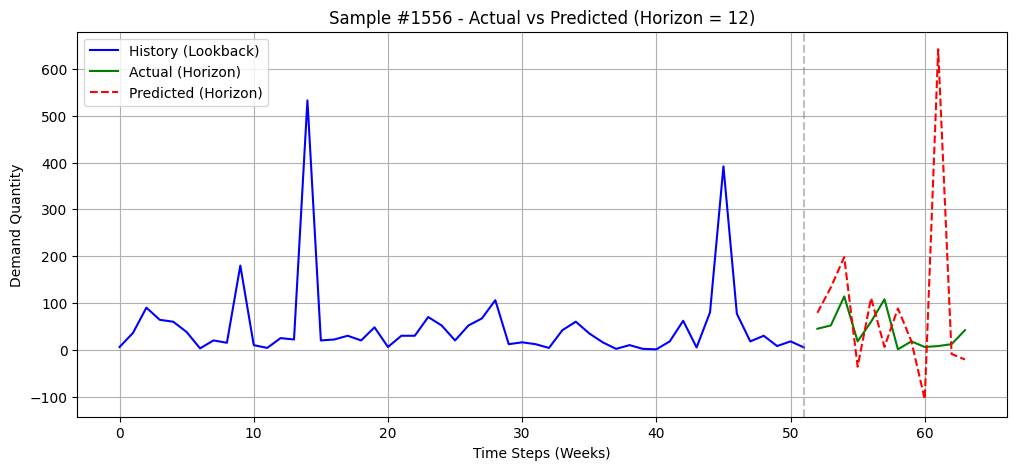

In [40]:
import matplotlib.pyplot as plt
import random
sample_idx = random.randint(0, len(val_dataset) - 1)

X_ts_sample, X_feat_sample, y_true_sample = val_dataset[sample_idx]
X_ts_sample = X_ts_sample.numpy().squeeze() # (Lookback, )
y_true_sample = y_true_sample.numpy() # (horizon, )

model.eval()
with torch.no_grad():
    X_ts_tensor = torch.tensor(X_ts_sample, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    X_feat_tensor = torch.tensor(X_feat_sample, dtype=torch.float32).unsqueeze(0).to(device)
    y_pred_scaled = model(X_ts_tensor, X_feat_tensor).cpu().numpy().flatten()

y_true = scaler_y.inverse_transform(y_true_sample.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

lookback_series = scaler_x.inverse_transform(X_ts_sample.reshape(-1, 1)).flatten()


plt.figure(figsize = (12, 5))
plt.plot(range(len(lookback_series)), lookback_series, label = 'History (Lookback)', color = 'blue')
plt.plot(range(len(lookback_series), len(lookback_series) + len(y_true)), y_true, label = 'Actual (Horizon)', color = 'green')
plt.plot(range(len(lookback_series), len(lookback_series) + len(y_pred)), y_pred, label = 'Predicted (Horizon)', color = 'red', linestyle = 'dashed')

plt.axvline(len(lookback_series)-1, color = 'gray', linestyle = '--', alpha = 0.5)
plt.title(f"Sample #{sample_idx} - Actual vs Predicted (Horizon = {horizon})")
plt.xlabel('Time Steps (Weeks)')
plt.ylabel('Demand Quantity')
plt.legend()
plt.grid(True)
plt.show()